## Attempt 6 U-Net

General Description - Training Dataset
The training database is composed of 100 patients as follows:
- 20 healthy patients
- 20 patients with previous myocardial infarction
- 20 patients with dilated cardiomyopathy
- 20 patients with an hyperthropic cardiomyopathy
- 20 patients with abnormal right ventrile

For all these data, the corresponding manual references given by one clinical expert along with additional information ont he patients are also provided

In [ ]:
pip install monai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.functional import relu
from torchvision import transforms
from PIL import Image
from enum import Enum
import monai
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
use_cuda = True

if torch.cuda.is_available():
  dev = "cuda:1"
else:
  dev = "cpu"
device = torch.device(dev)

device

device(type='cuda', index=1)

In [ ]:
class ACDCDataset(monai.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.label_paths = []

        # Assuming the directory structure is like: root_dir/patientXX/filename
        for patient_dir in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient_dir)
            if os.path.isdir(patient_path):
                for file_name in os.listdir(patient_path):
                    if file_name.endswith("_gt.nii.gz"):  # Ground truth segmentation masks end with '_gt.nii.gz'
                        label_path = os.path.join(patient_path, file_name)
                        image_path = label_path.replace("_gt.nii.gz", ".nii.gz")  # Corresponding image has the same name without '_gt'
                        self.image_paths.append(image_path)
                        self.label_paths.append(label_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # Load the image and label
        image = self.load_nifti_image(image_path)
        label = self.load_nifti_image(label_path)

        # Convert to PIL Images for consistent transformations
        image = Image.fromarray(image.astype(np.uint8))
        label = Image.fromarray(label.astype(np.uint8))

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        # Convert labels to tensor
        # label = torch.from_numpy(np.array(label, dtype=np.int64))

        # return image, label
        return {'img': image, 'label': label}

    def load_nifti_image(self, path):
        import nibabel as nib
        nifti_image = nib.load(path)
        image_data = nifti_image.get_fdata()
        image_data = image_data[:,:,0]
        return image_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dimensions torch.Size([1, 128, 128])


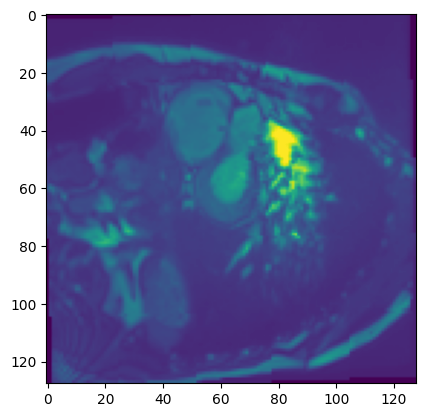

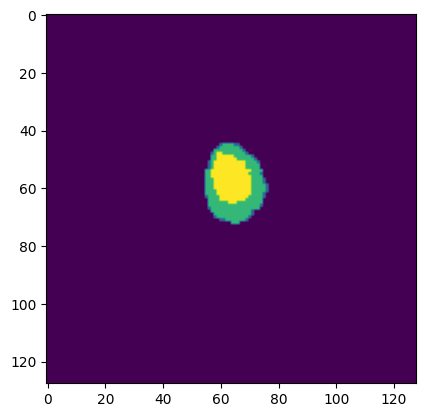

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(degrees=10),                           # AUGMENTATION: Random rotation up to ±10 degrees
    transforms.RandomHorizontalFlip(),                               # AUGMENTATION: Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

batch_size = 16

c, w, h = 3, 32, 32

# train_dataset = ACDCDataset(root_dir='./Resources/Database/Training',type=Type.train,transform=data_transforms)
train_dataset = ACDCDataset(root_dir='/content/drive/MyDrive/Resources/Database/training', transform=data_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ACDCDataset(root_dir='/content/drive/MyDrive/Resources/Database/testing', transform=data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# To check dimension after transformations
print('Dimensions', train_dataset[45]['img'].shape)

plt.figure()
plt.imshow(train_dataset[15]['img'].squeeze())
plt.show()

plt.figure()
plt.imshow(train_dataset[15]['label'].squeeze())
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def double_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
        #nn.BatchNorm2d(out_channel),
        #nn.ReLU(inplace=True),
        #nn.Dropout(0.3),
        nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
        #nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channel),
        #nn.Dropout(0.1)
    )
    return conv

def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]

class UNetV5(nn.Module):
    def __init__(self):
        super(UNetV5, self).__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride = 2)
        #self.down_conv_0 = double_conv(1, 64)
        self.down_conv_1 = double_conv(1, 128)
        self.down_conv_2 = double_conv(128, 256)
        self.down_conv_3 = double_conv(256, 512)
        self.down_conv_4 = double_conv(512, 1024)
        self.down_conv_5 = double_conv(1024, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2)

        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2)

        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2)

        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2)

        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=128,
            out_channels=1,
            kernel_size=1,
        )

        self.upsamp1 = nn.Upsample(scale_factor=2, mode='nearest')


    def forward(self, image):
        # bs, c, h, w
        # ENCODER
        #x00 = self.down_conv_0(image)
        #x0 = self.max_pool(x00)
        x1 = self.down_conv_1(image)
        x2 = self.max_pool(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool(x5)
        x7 = self.down_conv_4(x6)

        # DECODER
        x8 = self.up_trans_1(x7)
        y1 = crop_img(x5, x8)
        x9 = self.up_conv_1(torch.cat([x8, y1], 1))
        #x9 = self.upsamp1(x9)
        x10 = self.up_trans_2(x9)
        y2 = crop_img(x3, x10)
        x11 = self.up_conv_2(torch.cat([x10, y2], 1))
        #x11 = self.upsamp1(x11)
        x12 = self.up_trans_3(x11)
        y3 = crop_img(x1, x12)
        x13 = self.up_conv_3(torch.cat([x12, y3], 1))
        #x13 = self.upsamp1(x13)
        #x14 = self.up_trans_4(x13)
        #y4 = crop_img(x00, x14)
        #x15 = self.up_conv_4(torch.cat([x14, y4], 1))

        x = self.out(x13)
        return x

In [ ]:
#Source: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch?scriptVersionId=68471013&cellId=4
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [ ]:
# Set the model
#parameters = torch.load('V5trainedUNet.pt')
import torch
import torch.nn as nn

# Define the device to use (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelv5 = UNetV5()
modelv5 = modelv5.to(device)

# Defining the loss function (DICE)
#loss_function = monai.losses.DiceLoss(sigmoid=True, batch=True)
loss_function = nn.BCEWithLogitsLoss()
#loss_function = DiceLoss()
#loss_function = nn.CrossEntropyLoss()

# Defining the optimizer algorithm (Adam)
optimizer = torch.optim.Adam(modelv5.parameters(), lr=1e-3)

# Calculate steps per epoch for training and testing
trainSteps = len(train_dataset)//batch_size
testSteps = len(test_dataset)//batch_size

# calculate dice
#dice_train_fun = monai.metrics.compute_dice()
#dice_test_fun = monai.metrics.compute_dice()

# Initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "dice_train": [], "dice_test": []}


  0%|          | 0/10 [00:00<?, ?it/s]

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


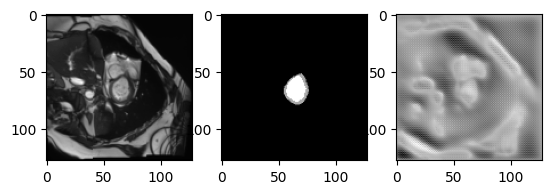

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


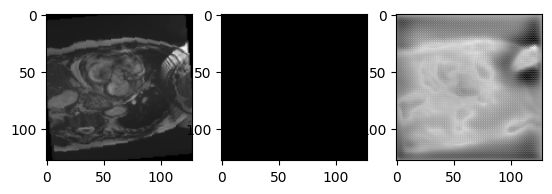

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


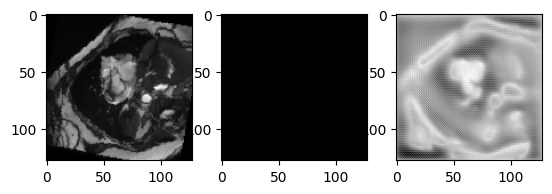

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


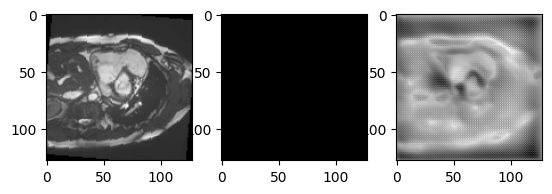

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


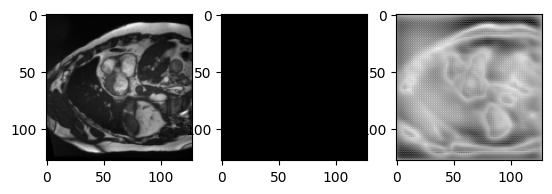

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


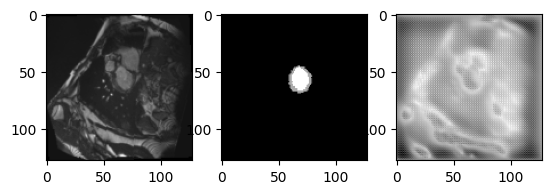

<Figure size 640x480 with 0 Axes>

pred = torch.Size([4, 1, 128, 128])
label =  torch.Size([4, 1, 128, 128])


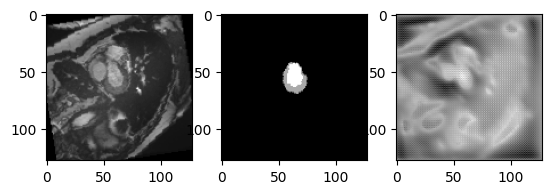

<Figure size 640x480 with 0 Axes>

 10%|█         | 1/10 [03:38<32:43, 218.17s/it]

[INFO] EPOCH: 1/10
Train Loss: 0.616739, Test Loss: 0.2906
loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}
pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


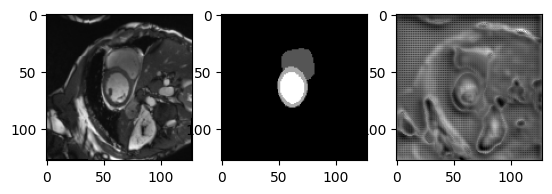

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


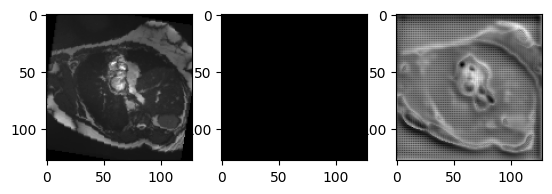

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


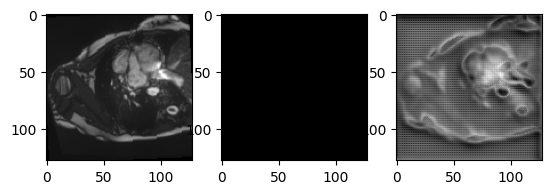

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


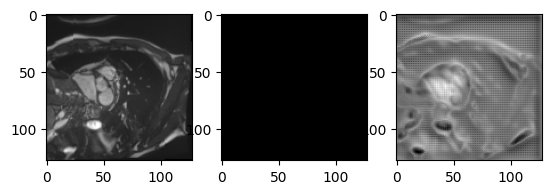

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


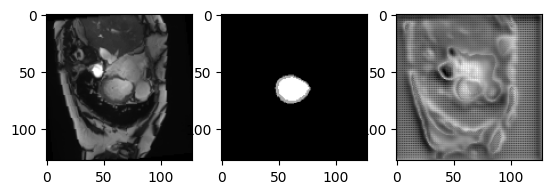

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


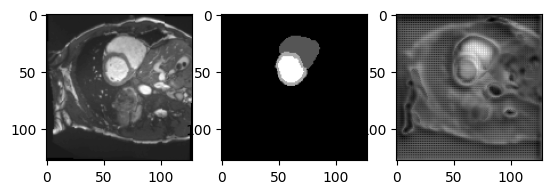

<Figure size 640x480 with 0 Axes>

pred = torch.Size([4, 1, 128, 128])
label =  torch.Size([4, 1, 128, 128])


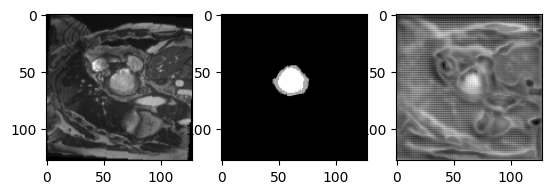

<Figure size 640x480 with 0 Axes>

 20%|██        | 2/10 [03:52<13:04, 98.09s/it] 

[INFO] EPOCH: 2/10
Train Loss: 0.445663, Test Loss: 0.4226
loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}
pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


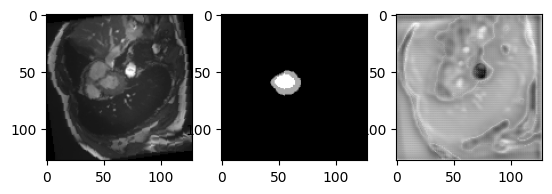

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


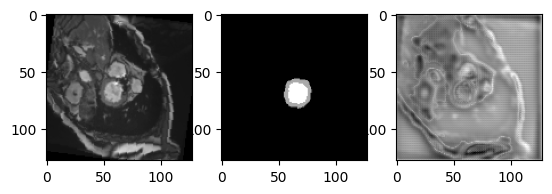

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


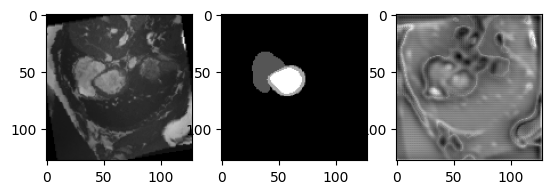

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


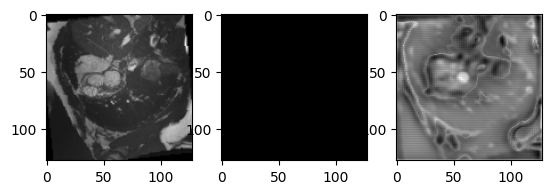

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


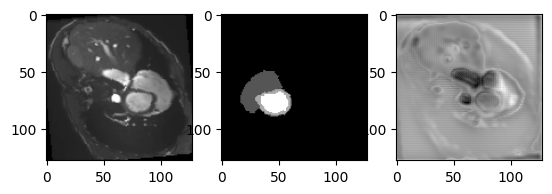

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


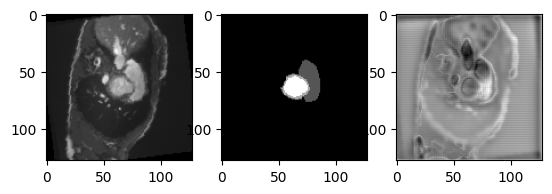

<Figure size 640x480 with 0 Axes>

pred = torch.Size([4, 1, 128, 128])
label =  torch.Size([4, 1, 128, 128])


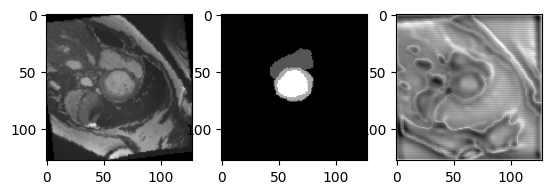

<Figure size 640x480 with 0 Axes>

 30%|███       | 3/10 [04:06<06:58, 59.80s/it]

[INFO] EPOCH: 3/10
Train Loss: 0.279005, Test Loss: 0.2083
loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}
pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


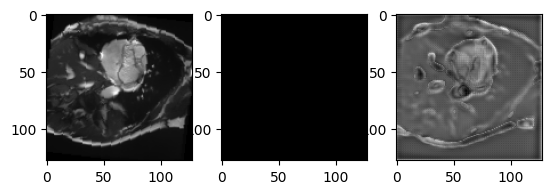

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


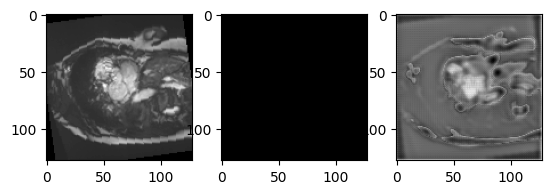

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


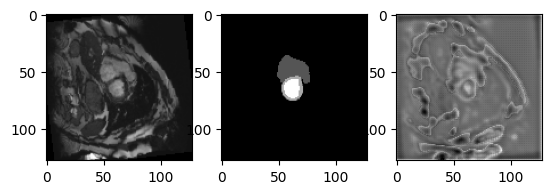

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


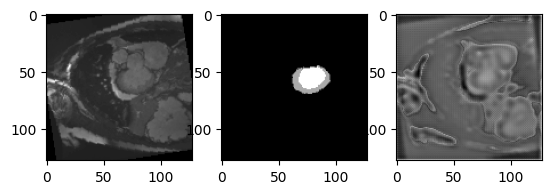

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


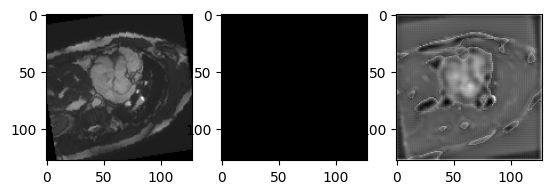

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


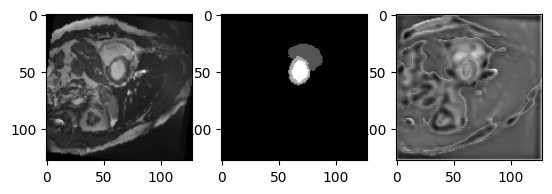

<Figure size 640x480 with 0 Axes>

pred = torch.Size([4, 1, 128, 128])
label =  torch.Size([4, 1, 128, 128])


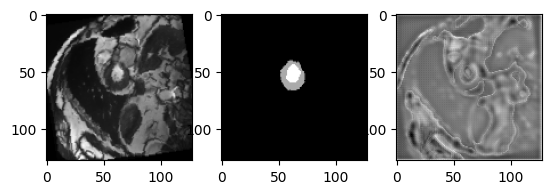

<Figure size 640x480 with 0 Axes>

 40%|████      | 4/10 [04:21<04:12, 42.07s/it]

[INFO] EPOCH: 4/10
Train Loss: 0.033903, Test Loss: -0.1050
loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}
pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


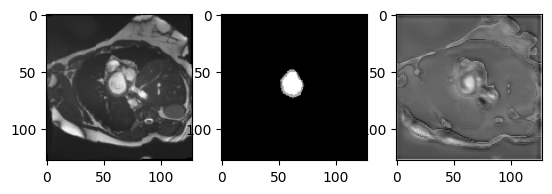

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


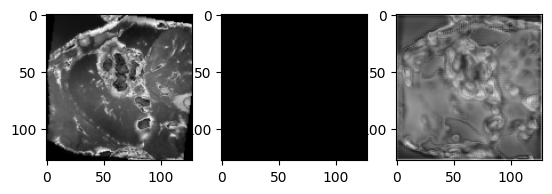

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


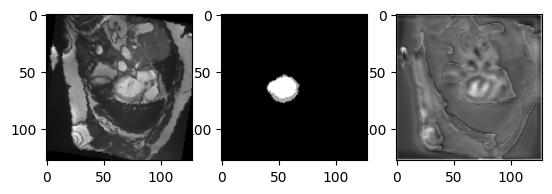

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


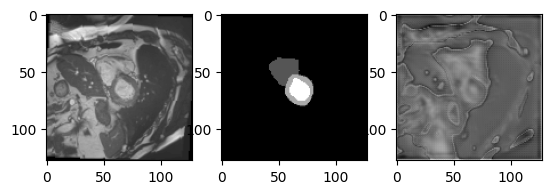

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


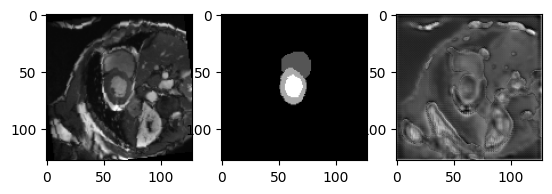

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


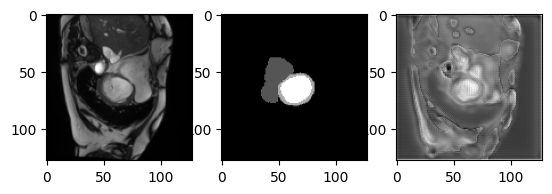

<Figure size 640x480 with 0 Axes>

pred = torch.Size([4, 1, 128, 128])
label =  torch.Size([4, 1, 128, 128])


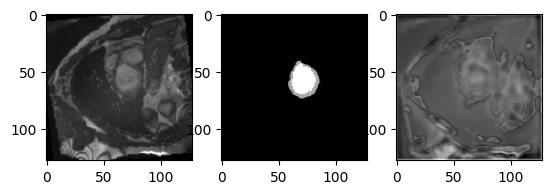

<Figure size 640x480 with 0 Axes>

 50%|█████     | 5/10 [04:35<02:40, 32.12s/it]

[INFO] EPOCH: 5/10
Train Loss: -0.312288, Test Loss: -0.4656
loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}
pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


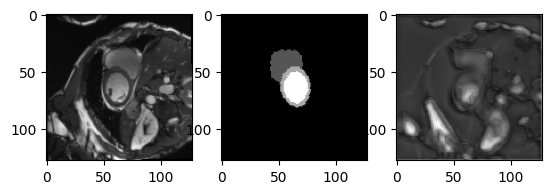

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


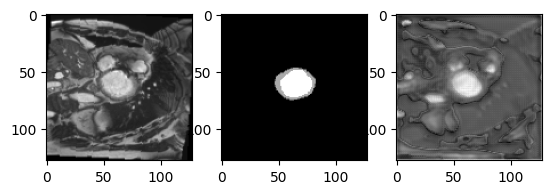

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


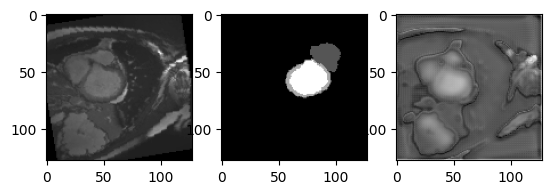

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


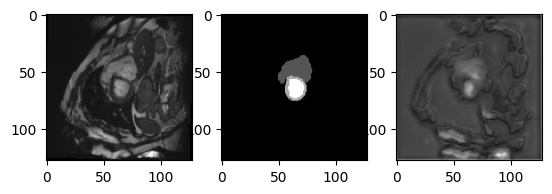

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


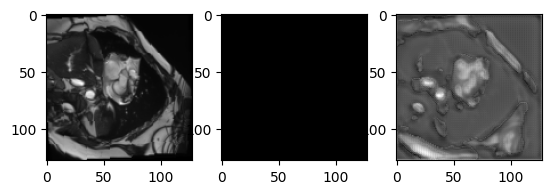

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


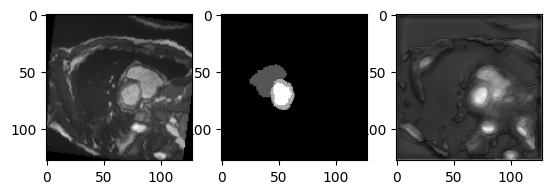

<Figure size 640x480 with 0 Axes>

pred = torch.Size([4, 1, 128, 128])
label =  torch.Size([4, 1, 128, 128])


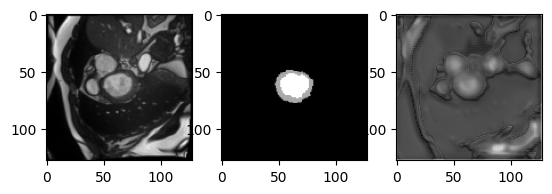

<Figure size 640x480 with 0 Axes>

 60%|██████    | 6/10 [04:50<01:44, 26.02s/it]

[INFO] EPOCH: 6/10
Train Loss: -0.762032, Test Loss: -0.9756
loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}
pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


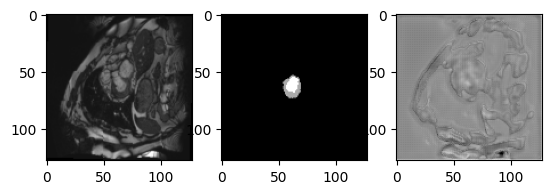

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


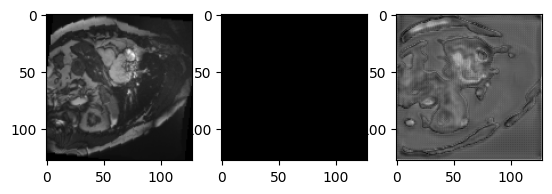

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


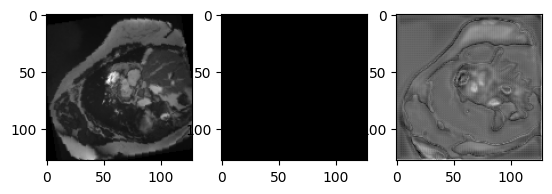

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


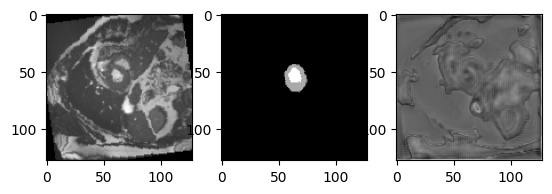

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


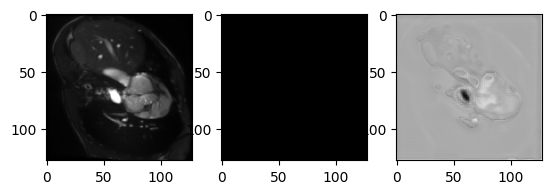

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


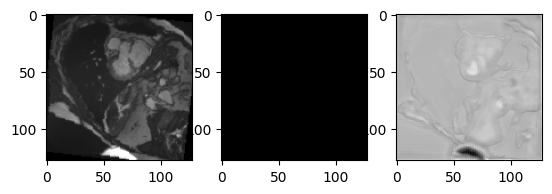

<Figure size 640x480 with 0 Axes>

pred = torch.Size([4, 1, 128, 128])
label =  torch.Size([4, 1, 128, 128])


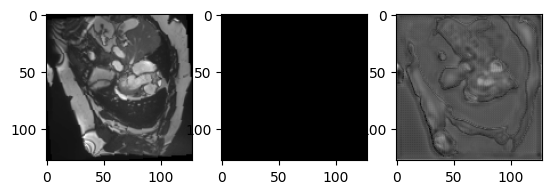

<Figure size 640x480 with 0 Axes>

 70%|███████   | 7/10 [05:04<01:06, 22.18s/it]

[INFO] EPOCH: 7/10
Train Loss: -1.304327, Test Loss: -1.5642
loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}
pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


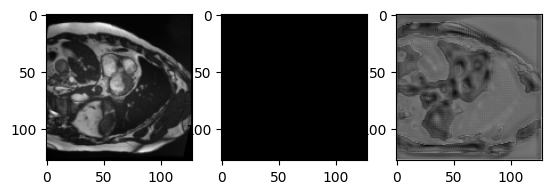

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


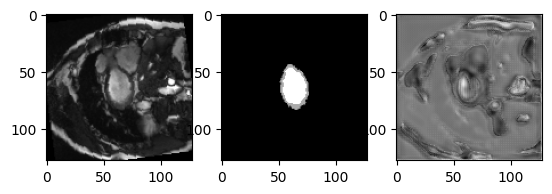

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


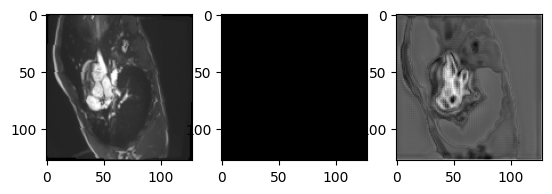

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


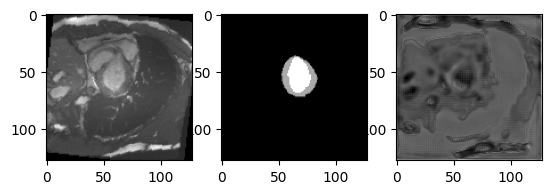

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


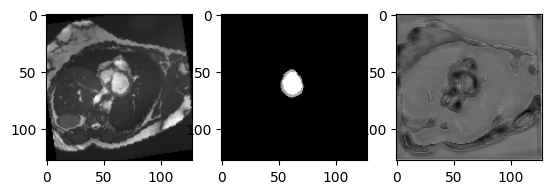

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


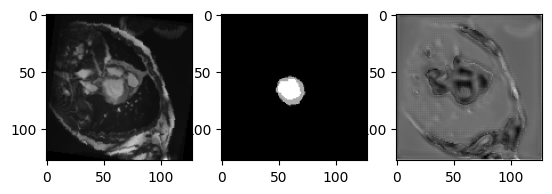

<Figure size 640x480 with 0 Axes>

pred = torch.Size([4, 1, 128, 128])
label =  torch.Size([4, 1, 128, 128])


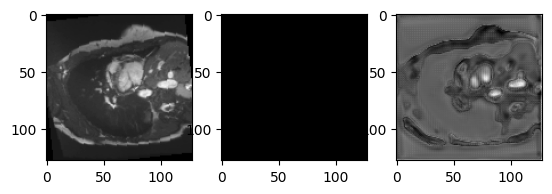

<Figure size 640x480 with 0 Axes>

 80%|████████  | 8/10 [05:19<00:39, 19.82s/it]

[INFO] EPOCH: 8/10
Train Loss: -1.926428, Test Loss: -2.2995
loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}
pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


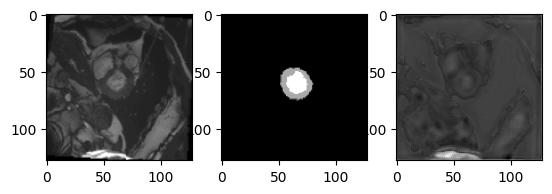

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


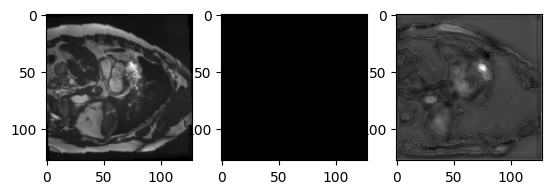

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


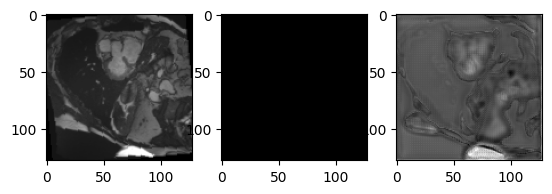

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


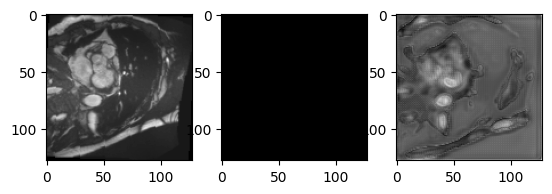

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


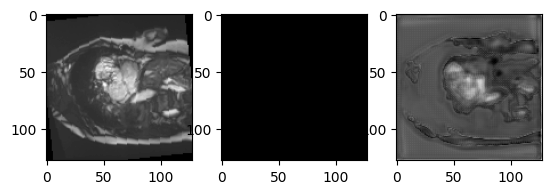

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


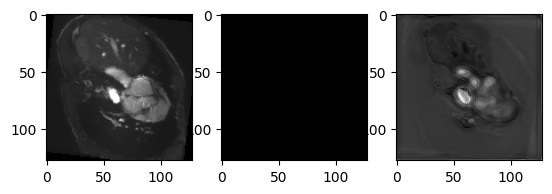

<Figure size 640x480 with 0 Axes>

pred = torch.Size([4, 1, 128, 128])
label =  torch.Size([4, 1, 128, 128])


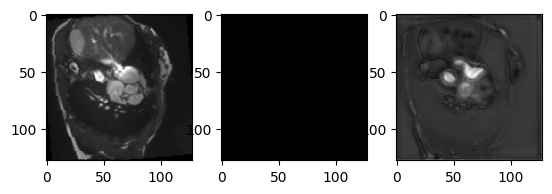

<Figure size 640x480 with 0 Axes>

 90%|█████████ | 9/10 [05:39<00:20, 20.14s/it]

[INFO] EPOCH: 9/10
Train Loss: -2.622063, Test Loss: -3.0844
loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}
pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


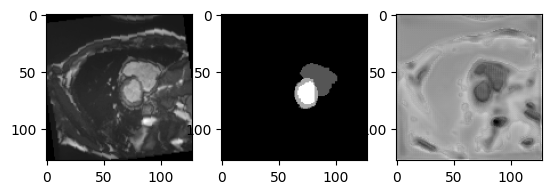

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


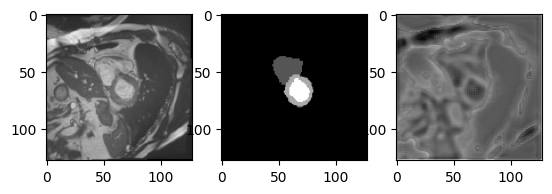

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


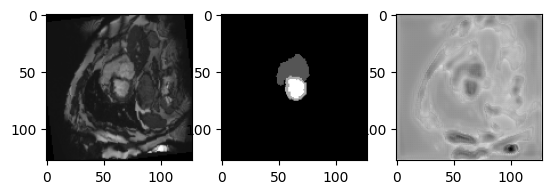

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


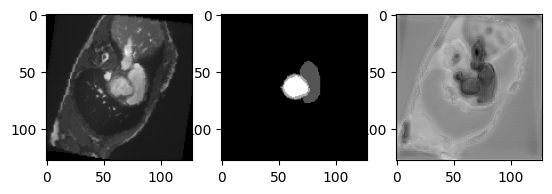

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


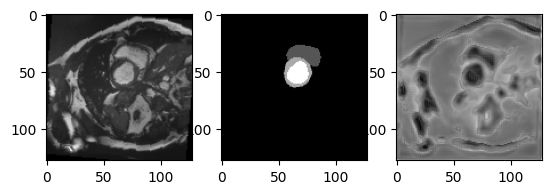

<Figure size 640x480 with 0 Axes>

pred = torch.Size([16, 1, 128, 128])
label =  torch.Size([16, 1, 128, 128])


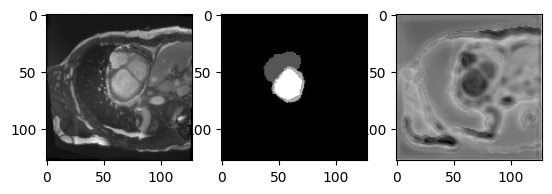

<Figure size 640x480 with 0 Axes>

pred = torch.Size([4, 1, 128, 128])
label =  torch.Size([4, 1, 128, 128])


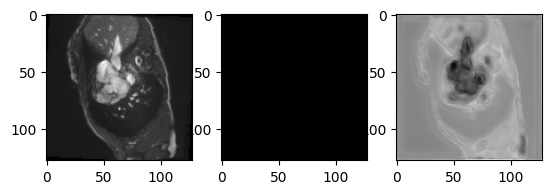

<Figure size 640x480 with 0 Axes>

100%|██████████| 10/10 [05:53<00:00, 35.39s/it]

[INFO] EPOCH: 10/10
Train Loss: -3.395338, Test Loss: -3.8754
loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}
[INFO] total time taken to train the model: 353.86s


In [ ]:
import time
from tqdm import tqdm
from monai import metrics
#import pyimagesearch
#from pyimagesearch import config, data_utils, model_utils, network

startTime = time.time()
num_epochs = 10

for e in tqdm(range(num_epochs)):
    # set the model in training mode
    modelv5.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    dice_train = 0
    dice_test = 0

    # loop over the training set
    for batch in train_dataloader:
        # send the input to the device
        image = batch['img'].float().to(device)
        label = batch['label'].float().to(device)

        # perform a forward pass and calculate training loss
        pred = modelv5(image)
        loss = loss_function(pred, label)
        #dice_train += (2 * (pred * label).sum()) / (2 * (pred * label).sum()+ ((pred*label)<1).sum())
        #dice_train += monai.metrics.compute_dice(pred, label)

        # first, zero out any previously accumulated gradients, then perform backpropagation, and then update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # add the loss to the total training loss so far
        totalTrainLoss += loss
        #dice_train += monai.metrics.compute_dice(pred, label, include_background=False)
        #dice_score_batch_train = model_utils.multi_class_dice_coeff(label, ypred)
        #epoch_dice_score_train += (dice_score_batch_train.item())

    # switch of autograd
    with torch.no_grad():
        # set model in evaluation mode
        modelv5.eval()

        # loop over the validation set
        for batch in test_dataloader:
            # send the input to the device
            image = batch['img'].float().to(device)
            label = batch['label'].float().to(device)
            #output = modelv4(image)

            # make the predictions and calculate the validation loss
            pred = modelv5(image)
            print('pred =', pred.size())
            print('label = ', label.size())
            totalTestLoss += loss_function(pred, label)
            #dice_test += (2 * (pred * label).sum()) / (2 * (pred * label).sum()+ ((pred*label)<1).sum())
            #dice_test += monai.metrics.compute_dice(pred, label)
            #dice_score_batch_test = model_utils.multi_class_dice_coeff(label, ypred)
            #epoch_dice_score_test += (dice_score_batch_test.item())

            images_cpu = image[0].cpu().detach().numpy()
            labels_cpu = label[0].cpu().detach().numpy()
            output_cpu = pred[0].cpu().detach().numpy()

            # Plot the output
            fig, (ax1,ax2,ax3) = plt.subplots(1,3)
            plt.figure()
            ax1.imshow(images_cpu.squeeze(), cmap='gray')
            ax2.imshow(labels_cpu.squeeze(), cmap='gray')
            ax3.imshow(output_cpu.squeeze(), cmap='gray')
            plt.show()

            output_max = torch.argmax(pred, dim=1)  # Get the labels with highest output probability
            correct = torch.sum(torch.eq(output_max, label)).item()  # Count how many are equal to the true labels

    # calculate the average training and validation loss
    avgTrainLoss =  totalTrainLoss / len(train_dataloader)
    avgTestLoss = totalTestLoss / len(test_dataloader)
    #dice_train_avg = dice_train / len(train_dataloader)
    #dice_test_avg = dice_test / len(test_dataloader)
    #avg_dice_epoch_train = epoch_dice_score_train / len(train_dataloader)
    #avg_dice_epoch_test = epoch_dice_score_test / len(test_dataloader)

    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    #H["dice_train"].append(dice_train_avg.cpu().detach().numpy())
    #H["dice_test"].append(dice_test_avg.cpu().detach().numpy())

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Train Loss: {:.6f}, Test Loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
    #print("Dice Test: {:.4f}".format(dice_test_avg))
    #print("Dice Train: {:.4f}, Dice Test: {:.4f}".format(dice_test_avg, dice_train_avg))
    print('loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}')



# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))




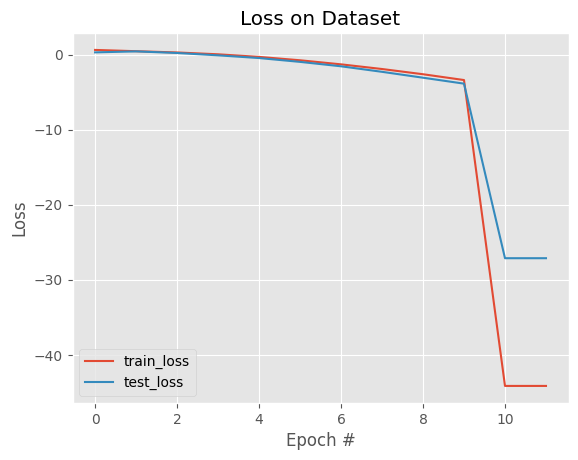

In [ ]:
#dice_train_avg = dice_train // (len(test_dataset)//batch_size)
#H["dice_train"].append(dice_train_avg.cpu().detach().numpy())
H["train_loss"].append(totalTrainLoss.cpu().detach().numpy())
H["test_loss"].append(totalTestLoss.cpu().detach().numpy())

plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
#plt.savefig(config.PLOT_PATH)

In [ ]:
# Attempt to calculate the DICE Score
#dice_train = monai.metrics.DiceMetric(train_loss)
from monai.metrics import DiceMetric

# Calculate the Dice Score
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import wandb
import torch

# initialize wandb run
run = wandb.init(
    project='V5_UNet_testing',
    name='Run_1',
    config={
        'loss function': str(loss_function),
        'lr': optimizer.param_groups[0]["lr"],
        'batch_size': train_dataloader.batch_size,
    }
)

run_id = run.id  # Remember the run ID to be able to write the evaluation metrics

def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """
    sigmoid = torch.nn.Sigmoid()

    # Convert numpy arrays to tensors
    mask_output = sigmoid(torch.tensor(mask_output))
    mask_output = torch.round(mask_output)

    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = torch.tensor(mask_gt).squeeze().detach().cpu().numpy()  # Convert to tensor

    class_labels = {1: 'ribs'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """
    log_imgs = [wandb.Image(img, masks=wandb_masks(mask_output, mask_gt)) for img, mask_output,
                mask_gt in zip(batch_data['img'], outputs, batch_data['label'])]

    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})

# Example training loop
for epoch in tqdm(range(num_epochs)):
    modelv5.train()
    totalTrainLoss = 0
    totalTestLoss = 0

    # training loop
    for batch in train_dataloader:
        image = batch['img'].float().to(device)
        label = batch['label'].float().to(device)

        pred = modelv5(image)
        loss = loss_function(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalTrainLoss += loss

    # validation loop
    with torch.no_grad():
        modelv5.eval()
        for batch in test_dataloader:
            image = batch['img'].float().to(device)
            label = batch['label'].float().to(device)

            pred = modelv5(image)
            totalTestLoss += loss_function(pred, label)

            images_cpu = image.cpu().detach().numpy()
            labels_cpu = label.cpu().detach().numpy()
            output_cpu = pred.cpu().detach().numpy()
            output_max = torch.argmax(pred, dim=1)
            correct = torch.sum(torch.eq(output_max, label)).item()

    avgTrainLoss = totalTrainLoss / len(train_dataloader)
    avgTestLoss = totalTestLoss / len(test_dataloader)

    # log the results to wandb
    log_to_wandb(epoch, avgTrainLoss, avgTestLoss, {'img': images_cpu, 'label': labels_cpu}, output_cpu)

# Store the network parameters
torch.save(modelv5.state_dict(), 'V5trainedUNet.pt')
run.finish()


100%|██████████| 10/10 [02:00<00:00, 12.03s/it]


In [ ]:
#SAVING RESULTS!!
import time
from tqdm import tqdm

startTime = time.time()
#secret_dataset = ACDCDataset(root_dir='./ACDC_secrettest', transform=data_transforms)
test_dataset = ACDCDataset(root_dir='./ACDC_data/testing',transform=data_transforms)
num_samples= len(secret_dataset)
#secret_dataloader = DataLoader(secret_dataset, batch_size=1, shuffle=True)
secret_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

#odel_secrettest = torch.load('V5trainedUNet.pt')

for e in tqdm(range(num_epochs)):

    totalTestLoss = 0
    test_epoch_loss = 0

    # switch of autograd
    with torch.no_grad():
        # set model in evaluation mode
        modelv5.eval()

        # loop over the validation set
        for batch in secret_dataloader:
            # send the input to the device
            image = batch['img'].float().to(device)
            label = batch['label'].float().to(device)

            # make the predictions and calculate the validation loss
            pred = modelv5(image)
            #segmentation_img = nib.Nifti1Image(pred, np.eye(4))
            #nib.save(segmentation_img, 'segmentation_results.nii')
            totalTestLoss += loss_function(pred, label)
            totalTestLoss += loss_function(pred, label)
            test_epoch_loss += totalTestLoss.item()
            steps += 1

            images_cpu = image[0].cpu().detach().numpy()
            labels_cpu = label[0].cpu().detach().numpy()
            output_cpu = pred[0].cpu().detach().numpy()

            
            fig, (ax1,ax2,ax3) = plt.subplots(1,3)
            plt.figure()
            ax1.imshow(images_cpu.squeeze(), cmap='gray')
            ax2.imshow(labels_cpu.squeeze(), cmap='gray')
            ax3.imshow(output_cpu.squeeze(), cmap='gray')
            plt.show()


            output_max = torch.argmax(pred, dim=1)  # Get the labels with highest output probability
            correct = torch.sum(torch.eq(output_max, label)).item()  # Count how many are equal to the true labels
    # calculate the average training and validation loss
    avgTestLoss = totalTestLoss / testSteps

# update our training history
#["test_loss"].append(avgTestLoss.cpu().detach().numpy())



# print the model training and validation information
print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
print("Test Loss: {:.4f}".format(avgTestLoss))
print('loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}')
endTime = time.time()
print("[INFO] total time taken to test the model: {:.2f}s".format(endTime - startTime))

In [ ]:
import time
from tqdm import tqdm

startTime = time.time()

secret_dataset = ACDCDataset(root_dir='./ACDC_secrettest', transform=data_transforms)
secret_dataloader = DataLoader(secret_dataset, batch_size=batch_size, shuffle=False)
num_epochs = len(secret_dataset)

model_secrettest = torch.load('V5trainedUNet.pt')

# trying to save the results
def save_segmentation_masks(output_masks, patient_id):
    output_folder = './segmentation_results'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # concatenated the output mask along the batch dimension
    combined_mask = np.concatenate(output_masks, axis = 0)

    # save the combined mask for the patient
    np.save(os.path.join(output_folder, 'f{patient_id}_segmentation_masks.nii'), combined_mask)

output_masks = []
#patient_ids = file_name in os.listdir
#file_name in os.listdir(patient_path):


for e in tqdm(range(num_epochs)):

    totalTestLoss = 0

    # switch of autograd
    with torch.no_grad():
        # set model in evaluation mode
        modelv5.eval()

        # loop over the validation set
        for batch in secret_dataloader:
            # send the input to the device
            image = batch['img'].float().to(device)
            label = batch['label'].float().to(device)

            # make the predictions and calculate the validation loss
            pred = modelv5(image)
            segmentation_img = nib.Nifti1Image(pred, np.eye(4))
            nib.save(segmentation_img, 'segmentation_results.nii')
            totalTestLoss += loss_function(pred, label)

            images_cpu = image[0].cpu().detach().numpy()
            labels_cpu = label[0].cpu().detach().numpy()
            output_cpu = pred[0].cpu().detach().numpy()

            
            fig, (ax1,ax2,ax3) = plt.subplots(1,3)
            plt.figure()
            ax1.imshow(images_cpu.squeeze(), cmap='gray')
            ax2.imshow(labels_cpu.squeeze(), cmap='gray')
            ax3.imshow(output_cpu.squeeze(), cmap='gray')
            plt.show()

            output_max = torch.argmax(pred, dim=1)  # Get the labels with highest output probability
            correct = torch.sum(torch.eq(output_max, label)).item()  # Count how many are equal to the true labels
            save_segmentation_masks(pred, 1)
    # calculate the average training and validation loss
    avgTestLoss = totalTestLoss / testSteps


# update our training history
#H["test_loss"].append(avgTestLoss.cpu().detach().numpy())



# print the model training and validation information
#print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
#print("Test Loss: {:.4f}".format(avgTestLoss))
#print('loss: {loss.item():.3f}, train accuracy: {float(correct) / float(batch_size):.6f}')
endTime = time.time()
print("[INFO] total time taken to test the model: {:.2f}s".format(endTime - startTime))

In [ ]:
from tqdm import tqdm
import wandb

run = wandb.init(
    project='V5_UNet_secrettestset',
    name='Run_1',
    config={
        'loss function': str(loss_function),
        'lr': optimizer.param_groups[0]["lr"],
        #transform': from_compose_to_list(train_dataset),
        'batch_size': train_dataloader.batch_size,
        #'image': modelv4(images)
        #'train_loss': str(avgTrainLoss),
        'test_loss': str(avgTestLoss),
        'images': images_cpu,
        'labels': labels_cpu,
        'pred' : output_cpu,
        'ouput_max' : output_max,
        'correct' : correct,
    }
)

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Apply sigmoid to model ouput and round to nearest integer (0 or 1)
    sigmoid = torch.nn.Sigmoid()
    mask_output = sigmoid(mask_output)
    mask_output = torch.round(mask_output)

    # Transform masks to numpy arrays on CPU
    # Note: .squeeze() removes all dimensions with a size of 1 (here, it makes the tensors 2-dimensional)
    # Note: .detach() removes a tensor from the computational graph to prevent gradient computation for it
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class label and insert masks
    class_labels = {1: 'Heart'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    log_imgs = [wandb.Image(img, masks=wandb_masks(mask_output, mask_gt)) for img, mask_output,
                mask_gt in zip(batch_data['img'], outputs, batch_data['mask'])]
    
    wandb.log({'epoch': 100, 'train_loss': avgTrainLoss, 'val_loss': avgTestLoss, 'results': log_imgs})

# Store the network parameters
torch.save(modelv5.state_dict(), r'V5trainedUNet.pt')
log_to_wandb(avgTrainLoss, avgTestLoss, images, labels, pred)
run.finish()